In [13]:
import sys
sys.path.append("D:/data/Kaggle/Severstal/tta_wrapper-master/")

In [1]:
#

import pandas as pd

train_df = pd.read_csv('D:/data/Kaggle/Severstal/train.csv')
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()

print(train_df.shape)
train_df.head()

(50272, 5)


,ImageId_ClassId,EncodedPixels,ImageId,ClassId,hasMask
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,True
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2,False
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3,False
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4,False
4,00031f466.jpg_1,NaN,00031f466.jpg,1,False


In [2]:
import numpy as np

mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(12568, 2)


,ImageId,hasMask
10803,db4867ee8.jpg,3.0
11776,ef24da2ba.jpg,3.0
6284,7f30b9c64.jpg,2.0
9421,bf0c81db6.jpg,2.0
9615,c314f43f3.jpg,2.0


In [3]:
#test测试集
import pandas

sub_df = pandas.read_csv('D:/data/Kaggle/Severstal/sample_submission.csv')
sub_df['ImageId'] = sub_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
sub_df.head()

,ImageId_ClassId,EncodedPixels,ImageId
0,004f40c73.jpg_1,1 1,004f40c73.jpg
1,004f40c73.jpg_2,1 1,004f40c73.jpg
2,004f40c73.jpg_3,1 1,004f40c73.jpg
3,004f40c73.jpg_4,1 1,004f40c73.jpg
4,006f39c41.jpg_1,1 1,006f39c41.jpg


In [4]:
test_imgs = pandas.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])#只根据图片名称建表
print(len(test_imgs))
test_imgs.head()

1801


,ImageId
0,004f40c73.jpg
1,006f39c41.jpg
2,00b7fb703.jpg
3,00bbcd9af.jpg
4,0108ce457.jpg


In [5]:
non_missing_train_idx = mask_count_df[mask_count_df['hasMask'] > 0]
non_missing_train_idx.head()

,ImageId,hasMask
10803,db4867ee8.jpg,3.0
11776,ef24da2ba.jpg,3.0
6284,7f30b9c64.jpg,2.0
9421,bf0c81db6.jpg,2.0
9615,c314f43f3.jpg,2.0


In [6]:
import cv2
import os

def load_img(code, base, resize=True):
    path = f'{base}/{code}'
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if resize:
        img = cv2.resize(img, (224, 224))
    
    return img

def validate_path(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [7]:
from tqdm import tqdm

test_path = 'D:/data/Kaggle/Severstal/tmp/test'
validate_path(test_path)

for code in tqdm(test_imgs['ImageId'].values):
    img = load_img(code, base=r'D:\data\Kaggle\Severstal/test_imgs')
    path = code.replace('.jpg', '')
    cv2.imwrite(f'{test_path}/{path}.png', img)

test_imgs['ImageId'] = test_imgs['ImageId'].apply(lambda x: x.replace('.jpg', '.png'))
sub_df['ImageId'] = sub_df['ImageId'].apply(lambda x: x.replace('.jpg', '.png'))

100%|█████████████████████████████████████████████████████████████████████████████| 1801/1801 [00:15<00:00, 118.46it/s]


In [8]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64

test_gen = ImageDataGenerator(rescale=1/255.).flow_from_dataframe(
        test_imgs,
        directory=test_path, #目标目录的路径，如果写了要包含在 dataframe 中映射的所有图像
        x_col='ImageId',
        class_mode=None,
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        shuffle=False #不打乱顺序
    )


Using TensorFlow backend.


Found 1801 images.


In [9]:
from keras.models import Model, load_model

remove_model = load_model('D:/data/Kaggle/Severstal/pre_model.h5')
remove_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

In [11]:
test_missing_pred = remove_model.predict_generator(
    test_gen,
    steps=len(test_gen),
    verbose=1
)

#test_imgs['missingCount'] = test_missing_pred.argmax(axis=1) + 1
test_imgs['allMissing'] = test_missing_pred #allMissing列值等于1代表没有给定的缺陷类型，即无缺陷
test_imgs.head()

,ImageId,allMissing
0,004f40c73.png,0.914483
1,006f39c41.png,0.999879
2,00b7fb703.png,0.999982
3,00bbcd9af.png,0.996996
4,0108ce457.png,0.999664


In [19]:
test_imgs['missingCount'].value_counts()

1    1801
Name: missingCount, dtype: int64

In [12]:
filtered_test_imgs = test_imgs[test_imgs['allMissing'] < 0.5]
print(filtered_test_imgs.shape)
filtered_test_imgs.head()

(770, 2)


,ImageId,allMissing
5,0109b68ec.png,0.070452
6,010ec96b4.png,0.002799
8,017bd7ce3.png,0.022317
10,01d49cd47.png,0.002857
11,020ffb2d3.png,0.058497


In [14]:
filtered_mask = sub_df['ImageId'].isin(filtered_test_imgs["ImageId"].values)
filtered_sub_df = sub_df[filtered_mask].copy()

null_sub_df = sub_df[~filtered_mask].copy()
null_sub_df['EncodedPixels'] = null_sub_df['EncodedPixels'].apply(lambda x: ' ')

filtered_sub_df['ImageId'] = filtered_sub_df['ImageId'].apply(
    lambda x: x.replace('.png', '.jpg'))
filtered_test_imgs['ImageId'] = filtered_test_imgs['ImageId'].apply(
    lambda x: x.replace('.png', '.jpg'))

filtered_sub_df.reset_index(drop=True, inplace=True)
filtered_test_imgs.reset_index(drop=True, inplace=True)

print(filtered_sub_df.shape)
print(null_sub_df.shape)

filtered_sub_df.head()

D:\Selvaria\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


(3080, 3)
(4124, 3)


,ImageId_ClassId,EncodedPixels,ImageId
0,0109b68ec.jpg_1,1 1,0109b68ec.jpg
1,0109b68ec.jpg_2,1 1,0109b68ec.jpg
2,0109b68ec.jpg_3,1 1,0109b68ec.jpg
3,0109b68ec.jpg_4,1 1,0109b68ec.jpg
4,010ec96b4.jpg_1,1 1,010ec96b4.jpg


In [15]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]
    
    starts = starts - 1

    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        
    return mask.reshape(height, width).T

def build_masks(rles, input_shape):
    depth = len(rles)
    masks = np.zeros((*input_shape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, input_shape)
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

print(train_df.loc[0,'EncodedPixels'])
mask_tensor = rle2mask(train_df.loc[0,'EncodedPixels'], (256,1600,1))
print(mask_tensor, mask_tensor.shape)
print(mask2rle(rle2mask(train_df.loc[0,'EncodedPixels'], (256,1600,1))))
mask2rle(rle2mask('1 1',((256,1600,1))))

29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 82265 105 82521 31 82556 69 82779 27 82818 63 83038 22 83080 57 83297 17 83342 50 83555 13 83604 44 83814 8 83866 37 84073 3 84128 31 84390 25 84652 18 84918 8 85239 10 85476 29 85714 47 85960 57 86216 57 86471 58 86727 58 86983 58 87238 59 87494 59 87750 59 88005 60 88261 60 88517 60 88772 61 89028 53 89283 40 89539 32 89667 10 89795 30 89923 28 90050 29 90179 37 90306 27 90434 38 90562 14 90690 38 90817 9 90946 38 91073 3 91202 38 91458 38 91714 38 91969 39 92225 39 92481 39 92737 39 92993 39 93248 40 93504 40 93760 40 94026 30 94302 10 189792 7 190034 21 190283 28 190539 28 190795 28 191051 28 191307 28 191563 28 191819 28 192075 28 192331 28 192587 28 192843 23 193099 14 193355 5
[[0 0 0 ... 0 

'1 1'

In [40]:
from skimage.color import gray2rgb
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='D:/data/Kaggle/Severstal/train_imgs',
                 batch_size=32, dim=(256, 1600), n_channels=3,
                 n_classes=4, random_state=2019, shuffle=True,aug=False):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        self.seq = aug
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
                
        X = self.__generate_X(list_IDs_batch)
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y.astype(int)
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_grayscale(img_path)
            
            # Store samples
            X[i,] = gray2rgb(img[:,:,0])

        return X
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks
        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

In [41]:
BATCH_SIZE = 8
import imgaug as ia
import imgaug.augmenters as iaa

from keras.models import Sequential
from sklearn.model_selection import train_test_split

seq = iaa.Sequential([
    iaa.Sharpen((0.0, 1.0)),       # sharpen the image
    iaa.Fliplr(),
    iaa.Flipud(),
    iaa.ElasticTransformation(alpha=50, sigma=5)  # apply water effect (affects segmaps)
], random_order=True)


train_idx, val_idx = train_test_split(
    non_missing_train_idx.index,  # NOTICE DIFFERENCE
    random_state=444, 
    test_size=0.15
)

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4,
    aug = seq
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4,
    aug = seq
)

In [66]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

i=0
plt.imshow(y[i].sum(axis=-1))

NameError: name 'y' is not defined

In [21]:
from keras.losses import binary_crossentropy

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply


from keras import optimizers
from keras.legacy import interfaces
from keras.utils.generic_utils import get_custom_objects

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.regularizers import l2
from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator


def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [62]:
import efficientnet as efn 

backbone = efn.EfficientNetB2(weights=None,
                            include_top=False,
                            input_shape=(None, None, 3))
backbone.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_898 (Conv2D)             (None, None, None, 3 864         input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_622 (BatchN (None, None, None, 3 128         conv2d_898[0][0]                 
__________________________________________________________________________________________________
swish_622 (Swish)               (None, None, None, 3 0           batch_normalization_622[0][0]    
__________________________________________________________________________________________________
depthwise_

activation_210 (Activation)     (None, 1, 1, 96)     0           conv2d_907[0][0]                 
__________________________________________________________________________________________________
multiply_210 (Multiply)         (None, None, None, 9 0           activation_210[0][0]             
                                                                 swish_628[0][0]                  
__________________________________________________________________________________________________
conv2d_908 (Conv2D)             (None, None, None, 2 2304        multiply_210[0][0]               
__________________________________________________________________________________________________
batch_normalization_629 (BatchN (None, None, None, 2 96          conv2d_908[0][0]                 
__________________________________________________________________________________________________
conv2d_909 (Conv2D)             (None, None, None, 1 3456        batch_normalization_629[0][0]    
__________

__________________________________________________________________________________________________
depthwise_conv2d_213 (Depthwise (None, None, None, 1 3600        swish_636[0][0]                  
__________________________________________________________________________________________________
batch_normalization_637 (BatchN (None, None, None, 1 576         depthwise_conv2d_213[0][0]       
__________________________________________________________________________________________________
swish_637 (Swish)               (None, None, None, 1 0           batch_normalization_637[0][0]    
__________________________________________________________________________________________________
lambda_213 (Lambda)             (None, 1, 1, 144)    0           swish_637[0][0]                  
__________________________________________________________________________________________________
conv2d_918 (Conv2D)             (None, 1, 1, 6)      870         lambda_213[0][0]                 
__________

__________________________________________________________________________________________________
conv2d_928 (Conv2D)             (None, None, None, 4 13824       multiply_215[0][0]               
__________________________________________________________________________________________________
batch_normalization_644 (BatchN (None, None, None, 4 192         conv2d_928[0][0]                 
__________________________________________________________________________________________________
drop_connect_149 (DropConnect)  (None, None, None, 4 0           batch_normalization_644[0][0]    
__________________________________________________________________________________________________
add_149 (Add)                   (None, None, None, 4 0           drop_connect_149[0][0]           
                                                                 add_148[0][0]                    
__________________________________________________________________________________________________
conv2d_929

__________________________________________________________________________________________________
swish_652 (Swish)               (None, None, None, 5 0           batch_normalization_652[0][0]    
__________________________________________________________________________________________________
lambda_218 (Lambda)             (None, 1, 1, 528)    0           swish_652[0][0]                  
__________________________________________________________________________________________________
conv2d_938 (Conv2D)             (None, 1, 1, 22)     11638       lambda_218[0][0]                 
__________________________________________________________________________________________________
swish_653 (Swish)               (None, 1, 1, 22)     0           conv2d_938[0][0]                 
__________________________________________________________________________________________________
conv2d_939 (Conv2D)             (None, 1, 1, 528)    12144       swish_653[0][0]                  
__________

                                                                 swish_658[0][0]                  
__________________________________________________________________________________________________
conv2d_948 (Conv2D)             (None, None, None, 1 63360       multiply_220[0][0]               
__________________________________________________________________________________________________
batch_normalization_659 (BatchN (None, None, None, 1 480         conv2d_948[0][0]                 
__________________________________________________________________________________________________
conv2d_949 (Conv2D)             (None, None, None, 7 86400       batch_normalization_659[0][0]    
__________________________________________________________________________________________________
batch_normalization_660 (BatchN (None, None, None, 7 2880        conv2d_949[0][0]                 
__________________________________________________________________________________________________
swish_660 

batch_normalization_667 (BatchN (None, None, None, 7 2880        depthwise_conv2d_223[0][0]       
__________________________________________________________________________________________________
swish_667 (Swish)               (None, None, None, 7 0           batch_normalization_667[0][0]    
__________________________________________________________________________________________________
lambda_223 (Lambda)             (None, 1, 1, 720)    0           swish_667[0][0]                  
__________________________________________________________________________________________________
conv2d_958 (Conv2D)             (None, 1, 1, 30)     21630       lambda_223[0][0]                 
__________________________________________________________________________________________________
swish_668 (Swish)               (None, 1, 1, 30)     0           conv2d_958[0][0]                 
__________________________________________________________________________________________________
conv2d_959

batch_normalization_674 (BatchN (None, None, None, 2 832         conv2d_968[0][0]                 
__________________________________________________________________________________________________
drop_connect_156 (DropConnect)  (None, None, None, 2 0           batch_normalization_674[0][0]    
__________________________________________________________________________________________________
add_156 (Add)                   (None, None, None, 2 0           drop_connect_156[0][0]           
                                                                 batch_normalization_671[0][0]    
__________________________________________________________________________________________________
conv2d_969 (Conv2D)             (None, None, None, 1 259584      add_156[0][0]                    
__________________________________________________________________________________________________
batch_normalization_675 (BatchN (None, None, None, 1 4992        conv2d_969[0][0]                 
__________

__________________________________________________________________________________________________
batch_normalization_682 (BatchN (None, None, None, 1 4992        depthwise_conv2d_228[0][0]       
__________________________________________________________________________________________________
swish_682 (Swish)               (None, None, None, 1 0           batch_normalization_682[0][0]    
__________________________________________________________________________________________________
lambda_228 (Lambda)             (None, 1, 1, 1248)   0           swish_682[0][0]                  
__________________________________________________________________________________________________
conv2d_978 (Conv2D)             (None, 1, 1, 52)     64948       lambda_228[0][0]                 
__________________________________________________________________________________________________
swish_683 (Swish)               (None, 1, 1, 52)     0           conv2d_978[0][0]                 
__________

__________________________________________________________________________________________________
batch_normalization_689 (BatchN (None, None, None, 3 1408        conv2d_988[0][0]                 
__________________________________________________________________________________________________
drop_connect_160 (DropConnect)  (None, None, None, 3 0           batch_normalization_689[0][0]    
__________________________________________________________________________________________________
add_160 (Add)                   (None, None, None, 3 0           drop_connect_160[0][0]           
                                                                 batch_normalization_686[0][0]    
__________________________________________________________________________________________________
conv2d_989 (Conv2D)             (None, None, None, 1 495616      add_160[0][0]                    
__________________________________________________________________________________________________
batch_norm

In [63]:
import efficientnet as efn 

def UEfficientNet(input_shape=(None, None, 3),dropout_rate=0.1):

#     backbone = efn.EfficientNetB2(weights=None,
#                             include_top=False,
#                             input_shape=input_shape)
#     backbone.load_weights("../input/efficientnet-keras-weights-b0b5/efficientnet-b2_imagenet_1000_notop.h5")
    #print(backbone.summary())
    inputs = backbone.input
    start_neurons = 8
    
    #i=2
    lr = []
    for l in backbone.layers:
        print(l.name)
        if 'batch_normalization' in l.name:
            lr.append(l)
            #i+=1

    print(len(lr))
    conv4 = lr[-1].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    deconv4_up1 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4)
    deconv4_up2 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up1)
    deconv4_up3 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up2)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4) 
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
#     uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)  #conv1_2
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3_up1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3)
    deconv3_up2 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3_up1)
    conv3 = lr[-2].output
    uconv3 = concatenate([deconv3,deconv4_up1, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
#     uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    deconv2_up1 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(deconv2)
    conv2 = lr[-4].output
    uconv2 = concatenate([deconv2,deconv3_up1,deconv4_up2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
#     uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = lr[-5].output
    uconv1 = concatenate([deconv1,deconv2_up1,deconv3_up2,deconv4_up3, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
#     uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
#     uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv0) 
    output_layer = Conv2D(4, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(inputs, output_layer)
    model.name = 'u-xception'

    return model

In [64]:
model = UEfficientNet((256,1600,3))
model.summary()

input_14
conv2d_898
batch_normalization_622
swish_622
depthwise_conv2d_208
batch_normalization_623
swish_623
lambda_208
conv2d_899
swish_624
conv2d_900
activation_208
multiply_208
conv2d_901
batch_normalization_624
depthwise_conv2d_209
batch_normalization_625
swish_625
lambda_209
conv2d_902
swish_626
conv2d_903
activation_209
multiply_209
conv2d_904
batch_normalization_626
drop_connect_145
add_145
conv2d_905
batch_normalization_627
swish_627
depthwise_conv2d_210
batch_normalization_628
swish_628
lambda_210
conv2d_906
swish_629
conv2d_907
activation_210
multiply_210
conv2d_908
batch_normalization_629
conv2d_909
batch_normalization_630
swish_630
depthwise_conv2d_211
batch_normalization_631
swish_631
lambda_211
conv2d_910
swish_632
conv2d_911
activation_211
multiply_211
conv2d_912
batch_normalization_632
drop_connect_146
add_146
conv2d_913
batch_normalization_633
swish_633
depthwise_conv2d_212
batch_normalization_634
swish_634
lambda_212
conv2d_914
swish_635
conv2d_915
activation_212
mult

conv2d_901 (Conv2D)             (None, None, None, 1 512         multiply_208[0][0]               
__________________________________________________________________________________________________
batch_normalization_624 (BatchN (None, None, None, 1 64          conv2d_901[0][0]                 
__________________________________________________________________________________________________
depthwise_conv2d_209 (Depthwise (None, None, None, 1 144         batch_normalization_624[0][0]    
__________________________________________________________________________________________________
batch_normalization_625 (BatchN (None, None, None, 1 64          depthwise_conv2d_209[0][0]       
__________________________________________________________________________________________________
swish_625 (Swish)               (None, None, None, 1 0           batch_normalization_625[0][0]    
__________________________________________________________________________________________________
lambda_209

__________________________________________________________________________________________________
multiply_211 (Multiply)         (None, None, None, 1 0           activation_211[0][0]             
                                                                 swish_631[0][0]                  
__________________________________________________________________________________________________
conv2d_912 (Conv2D)             (None, None, None, 2 3456        multiply_211[0][0]               
__________________________________________________________________________________________________
batch_normalization_632 (BatchN (None, None, None, 2 96          conv2d_912[0][0]                 
__________________________________________________________________________________________________
drop_connect_146 (DropConnect)  (None, None, None, 2 0           batch_normalization_632[0][0]    
__________________________________________________________________________________________________
add_146 (A

depthwise_conv2d_214 (Depthwise (None, None, None, 2 7200        swish_639[0][0]                  
__________________________________________________________________________________________________
batch_normalization_640 (BatchN (None, None, None, 2 1152        depthwise_conv2d_214[0][0]       
__________________________________________________________________________________________________
swish_640 (Swish)               (None, None, None, 2 0           batch_normalization_640[0][0]    
__________________________________________________________________________________________________
lambda_214 (Lambda)             (None, 1, 1, 288)    0           swish_640[0][0]                  
__________________________________________________________________________________________________
conv2d_922 (Conv2D)             (None, 1, 1, 12)     3468        lambda_214[0][0]                 
__________________________________________________________________________________________________
swish_641 

activation_216 (Activation)     (None, 1, 1, 288)    0           conv2d_931[0][0]                 
__________________________________________________________________________________________________
multiply_216 (Multiply)         (None, None, None, 2 0           activation_216[0][0]             
                                                                 swish_646[0][0]                  
__________________________________________________________________________________________________
conv2d_932 (Conv2D)             (None, None, None, 8 25344       multiply_216[0][0]               
__________________________________________________________________________________________________
batch_normalization_647 (BatchN (None, None, None, 8 352         conv2d_932[0][0]                 
__________________________________________________________________________________________________
conv2d_933 (Conv2D)             (None, None, None, 5 46464       batch_normalization_647[0][0]    
__________

__________________________________________________________________________________________________
depthwise_conv2d_219 (Depthwise (None, None, None, 5 4752        swish_654[0][0]                  
__________________________________________________________________________________________________
batch_normalization_655 (BatchN (None, None, None, 5 2112        depthwise_conv2d_219[0][0]       
__________________________________________________________________________________________________
swish_655 (Swish)               (None, None, None, 5 0           batch_normalization_655[0][0]    
__________________________________________________________________________________________________
lambda_219 (Lambda)             (None, 1, 1, 528)    0           swish_655[0][0]                  
__________________________________________________________________________________________________
conv2d_942 (Conv2D)             (None, 1, 1, 22)     11638       lambda_219[0][0]                 
__________

__________________________________________________________________________________________________
conv2d_952 (Conv2D)             (None, None, None, 1 86400       multiply_221[0][0]               
__________________________________________________________________________________________________
batch_normalization_662 (BatchN (None, None, None, 1 480         conv2d_952[0][0]                 
__________________________________________________________________________________________________
drop_connect_153 (DropConnect)  (None, None, None, 1 0           batch_normalization_662[0][0]    
__________________________________________________________________________________________________
add_153 (Add)                   (None, None, None, 1 0           drop_connect_153[0][0]           
                                                                 batch_normalization_659[0][0]    
__________________________________________________________________________________________________
conv2d_953

swish_669 (Swish)               (None, None, None, 7 0           batch_normalization_669[0][0]    
__________________________________________________________________________________________________
depthwise_conv2d_224 (Depthwise (None, None, None, 7 18000       swish_669[0][0]                  
__________________________________________________________________________________________________
batch_normalization_670 (BatchN (None, None, None, 7 2880        depthwise_conv2d_224[0][0]       
__________________________________________________________________________________________________
swish_670 (Swish)               (None, None, None, 7 0           batch_normalization_670[0][0]    
__________________________________________________________________________________________________
lambda_224 (Lambda)             (None, 1, 1, 720)    0           swish_670[0][0]                  
__________________________________________________________________________________________________
conv2d_962

                                                                 swish_676[0][0]                  
__________________________________________________________________________________________________
conv2d_972 (Conv2D)             (None, None, None, 2 259584      multiply_226[0][0]               
__________________________________________________________________________________________________
batch_normalization_677 (BatchN (None, None, None, 2 832         conv2d_972[0][0]                 
__________________________________________________________________________________________________
drop_connect_157 (DropConnect)  (None, None, None, 2 0           batch_normalization_677[0][0]    
__________________________________________________________________________________________________
add_157 (Add)                   (None, None, None, 2 0           drop_connect_157[0][0]           
                                                                 add_156[0][0]                    
__________

__________________________________________________________________________________________________
swish_684 (Swish)               (None, None, None, 1 0           batch_normalization_684[0][0]    
__________________________________________________________________________________________________
depthwise_conv2d_229 (Depthwise (None, None, None, 1 11232       swish_684[0][0]                  
__________________________________________________________________________________________________
batch_normalization_685 (BatchN (None, None, None, 1 4992        depthwise_conv2d_229[0][0]       
__________________________________________________________________________________________________
swish_685 (Swish)               (None, None, None, 1 0           batch_normalization_685[0][0]    
__________________________________________________________________________________________________
lambda_229 (Lambda)             (None, 1, 1, 1248)   0           swish_685[0][0]                  
__________

conv2d_992 (Conv2D)             (None, None, None, 2 590080      leaky_re_lu_3[0][0]              
__________________________________________________________________________________________________
batch_normalization_694 (BatchN (None, None, None, 2 1024        conv2d_992[0][0]                 
__________________________________________________________________________________________________
batch_normalization_692 (BatchN (None, None, None, 2 1024        conv2d_990[0][0]                 
__________________________________________________________________________________________________
add_161 (Add)                   (None, None, None, 2 0           batch_normalization_694[0][0]    
                                                                 batch_normalization_692[0][0]    
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, None, None, 2 0           add_161[0][0]                    
__________

conv2d_1000 (Conv2D)            (None, None, None, 6 36928       leaky_re_lu_11[0][0]             
__________________________________________________________________________________________________
batch_normalization_706 (BatchN (None, None, None, 6 256         conv2d_1000[0][0]                
__________________________________________________________________________________________________
batch_normalization_704 (BatchN (None, None, None, 6 256         conv2d_998[0][0]                 
__________________________________________________________________________________________________
add_164 (Add)                   (None, None, None, 6 0           batch_normalization_706[0][0]    
                                                                 batch_normalization_704[0][0]    
__________________________________________________________________________________________________
leaky_re_lu_12 (LeakyReLU)      (None, None, None, 6 0           add_164[0][0]                    
__________

                                                                 batch_normalization_712[0][0]    
__________________________________________________________________________________________________
leaky_re_lu_18 (LeakyReLU)      (None, None, None, 1 0           add_166[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose_26 (Conv2DTran (None, None, None, 8 1160        leaky_re_lu_18[0][0]             
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, None, None, 8 0           conv2d_transpose_26[0][0]        
__________________________________________________________________________________________________
conv2d_1007 (Conv2D)            (None, None, None, 8 584         dropout_6[0][0]                  
__________________________________________________________________________________________________
leaky_re_l

In [67]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])#使用之前写的评分函数

In [72]:
from keras import backend as K
from keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [74]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate

inputs = Input((256, 1600, 3)) #原图尺寸，黑白单通道

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5) #到这里一直是在对原始的input进行层操作变换

c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5) #开始对原始的input进行变换，直到u6的反向卷积
c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

#应该是使用了残差连接，用于避免梯度消失和表示瓶颈
u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55) #转置卷积层 (有时被成为反卷积)，将具有该卷积层输出shape的tensor转换为具有该卷积层输入shape的tensor。同时保留与卷积层兼容的连接模式
u6 = concatenate([u6, c5]) #和上一步在一起，相当于降维后连结在一起，和之前的维度相同。默认axis=-1(最后一个轴)，相当于按照c5[-1轴],u6[-1轴]拼接，即
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u71 = concatenate([u71, c4])
c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])#使用之前写的评分函数
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 256, 1600, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1011 (Conv2D)            (None, 256, 1600, 8) 224         input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_1012 (Conv2D)            (None, 256, 1600, 8) 584         conv2d_1011[0][0]                
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 128, 800, 8)  0           conv2d_1012[0][0]                
__________________________________________________________________________________________________
conv2d_101

conv2d_1032 (Conv2D)            (None, 256, 1600, 8) 584         conv2d_1031[0][0]                
__________________________________________________________________________________________________
conv2d_1033 (Conv2D)            (None, 256, 1600, 4) 36          conv2d_1032[0][0]                
Total params: 600,756
Trainable params: 600,756
Non-trainable params: 0
__________________________________________________________________________________________________


In [68]:
from keras.callbacks import Callback, ModelCheckpoint

checkpoint = ModelCheckpoint(
    'D:/data/Kaggle/Severstal/model_2.1.h5', 
    monitor='val_loss', 
    verbose=2, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=1,
    epochs=10
)

Epoch 1/10


InvalidArgumentError: All dimensions except 3 must match. Input 2 has shape [8 8 50 352] and doesn't match input 0 with shape [8 16 100 64].
	 [[{{node training_3/Adam/gradients/concatenate_17/concat_grad/ConcatOffset}} = ConcatOffset[N=3, _class=["loc:@train.../cond_grad"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](training_3/Adam/gradients/concatenate_16/concat_grad/mod, training_3/Adam/gradients/concatenate_17/concat_grad/ShapeN, training_3/Adam/gradients/concatenate_17/concat_grad/ShapeN:1, training_3/Adam/gradients/concatenate_17/concat_grad/ShapeN:2)]]

In [47]:
model.save('D:/data/Kaggle/Severstal/model_2.1.h5')

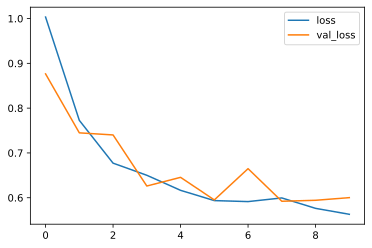

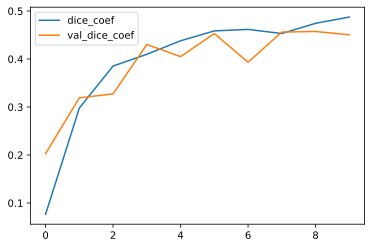

In [46]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

history_df = pandas.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

In [52]:
#tta模块，用不了

from tta_wrapper import tta_segmentation

model.load_model('D:/data/Kaggle/Severstal/model_2.1.h5')
test_df = []
tta_model = tta_segmentation(model, h_flip=True, h_shift=(-10, 10),mul =[0.95], merge='mean')

for i in range(0, filtered_test_imgs.shape[0], 300):
    batch_idx = list(
        range(i, min(filtered_test_imgs.shape[0], i + 300))
    )
    
    test_generator = DataGenerator(
        batch_idx,
        df=filtered_test_imgs,
        shuffle=False,
        mode='predict',
        base_path='D:/data/Kaggle/Severstal/test_imgs',
        target_df=filtered_sub_df,
        batch_size=1,
        n_classes=4,
        aug = None
    )
    
    batch_pred_masks = tta_model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1,
        use_multiprocessing=False
    )
    
    for j, b in tqdm(enumerate(batch_idx)):
        filename = filtered_test_imgs['ImageId'].iloc[b]
        image_df = filtered_sub_df[filtered_sub_df['ImageId'] == filename].copy()
        
#         pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_masks = batch_pred_masks[j, ]
        pred_masks[pred_masks<0.95]=0
        pred_masks[pred_masks>0.5]=1
        pred_rles = build_rles(pred_masks.astype(int))
        
        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)
        
    gc.collect()

AttributeError: Layer model_8 has multiple inbound nodes, hence the notion of "layer input" is ill-defined. Use `get_input_at(node_index)` instead.

In [75]:
import gc
from tqdm import tqdm
from keras.models import load_model

model.load_weights('D:/data/Kaggle/Severstal/model_2.1.h5')
#model = load_model('D:/data/Kaggle/Severstal/model_2.1.h5')
test_df = []

for i in range(0, filtered_test_imgs.shape[0], 300):
    batch_idx = list(
        range(i, min(filtered_test_imgs.shape[0], i + 300))
    )
    
    test_generator = DataGenerator(
        batch_idx,
        df=filtered_test_imgs,
        shuffle=False,
        mode='predict',
        base_path='D:/data/Kaggle/Severstal/test_imgs',
        target_df=filtered_sub_df,
        batch_size=1,
        n_classes=4
    )
    
    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=0,
        use_multiprocessing=False
    )
    
    for j, b in tqdm(enumerate(batch_idx)):
        filename = filtered_test_imgs['ImageId'].iloc[b]
        image_df = filtered_sub_df[filtered_sub_df['ImageId'] == filename].copy()
        
        pred_masks = batch_pred_masks[j, ].round().astype(int) #round()是numpy的函数，是将张量内的所有元素五舍六入到整数
        pred_rles = build_rles(pred_masks)
        
        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)
        
    gc.collect()

300it [00:23, 12.85it/s]
300it [00:24, 12.69it/s]
170it [00:13, 12.79it/s]


In [76]:
test_df = pandas.concat(test_df)
print(test_df.shape)
test_df.head()

(3080, 3)


,ImageId_ClassId,EncodedPixels,ImageId
0,0109b68ec.jpg_1,,0109b68ec.jpg
1,0109b68ec.jpg_2,,0109b68ec.jpg
2,0109b68ec.jpg_3,34913 11 35162 22 35414 28 35668 33 35922 36 3...,0109b68ec.jpg
3,0109b68ec.jpg_4,,0109b68ec.jpg
4,010ec96b4.jpg_1,,010ec96b4.jpg


In [77]:
final_submission_df = pandas.concat([test_df, null_sub_df])
print(final_submission_df.shape)
final_submission_df.head(20)

(7204, 3)


,ImageId_ClassId,EncodedPixels,ImageId
0,0109b68ec.jpg_1,,0109b68ec.jpg
1,0109b68ec.jpg_2,,0109b68ec.jpg
2,0109b68ec.jpg_3,34913 11 35162 22 35414 28 35668 33 35922 36 3...,0109b68ec.jpg
3,0109b68ec.jpg_4,,0109b68ec.jpg
4,010ec96b4.jpg_1,,010ec96b4.jpg
5,010ec96b4.jpg_2,,010ec96b4.jpg
6,010ec96b4.jpg_3,35317 11 35566 19 35819 22 36073 24 36328 25 3...,010ec96b4.jpg
7,010ec96b4.jpg_4,,010ec96b4.jpg
8,017bd7ce3.jpg_1,,017bd7ce3.jpg
9,017bd7ce3.jpg_2,,017bd7ce3.jpg


In [78]:
for index in final_submission_df.index:
    e_pixels = str(final_submission_df['EncodedPixels'].iloc[index])
    if len(e_pixels)>1 and len(e_pixels)< 3:
        print(e_pixels)
print('check end')

check end


In [79]:
final_submission_df[['ImageId_ClassId', 'EncodedPixels']].to_csv('D:/data/Kaggle/Severstal/submission_2.csv', index=False)